# Delivery Vehicle Routing

Consider the following problem:

A delivery person is given a list of dropoff locations for his/her daily route. Our goal then is to reach all of our target destinations in as short of a distance as possible. Alternatively, we could also consider other objectives to optimize for, either separately or at the same time:

- shortest time
- number of left turns
- avoiding highways
- eco-friendly routes
- avoid residential areas

In [1]:
import pandas as pd
import math
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
from smart_mobility_utilities.poi import poi, drawPOIS, drawRouteOrder

In [2]:
# You can use different excel data
file_path = '../../data/rideshare_GA/rideshare_dropoff.csv'
df = pd.read_csv(file_path)
numberOfStops = len(df)

In [3]:
POIS = []
for _ in df.itertuples():
    POIS.append(poi(_.Address,"canada",_.Latitude, _.Longitude))
POIS

[Name: Bay Street ID: 1601697722,
 Name: 653 ID: 76112568,
 Name: Castle Frank ID: 43804186,
 Name: 719-721 ID: 363349504,
 Name: Coxwell Avenue ID: 420539103,
 Name: Don Mills Road ID: 31653252,
 Name: 3945 ID: 76130372,
 Name: Fit for Life ID: 1561890202,
 Name: Dupont ID: 5320349317,
 Name: Finch ID: 561044357,
 Name: 1380 ID: 66246309,
 Name: Scarborough Southwest ID: 685674284,
 Name: Donlands Avenue ID: 420539141,
 Name: Kipling Station ID: 32052148,
 Name: 1870 ID: 67739333,
 Name: Canadian Tire/TVO ID: 95758198]

In [4]:
drawPOIS(POIS, zoom=10)

Map(center=[43.70017248810806, -79.3957161482716], close_popup_on_click=False, controls=(ZoomControl(options=[…

In [5]:
G = nx.DiGraph()
G.add_nodes_from(POIS)

In [6]:
# this will take 3-4 minutes because you need to find
# two routes between each pair of POIs
durations = []
pbar = tqdm(total=len(G.nodes())**2)
for source in G.nodes():
    duration = []
    for destination in G.nodes():
        pbar.update()
        if source == destination: 
            duration.append(0)
            continue
        G.add_edge(source, destination, route = source.route_to(destination))
        route = source.route_to(destination)
        duration.append(route['duration'])
    durations.append(duration)

  0%|          | 0/256 [00:00<?, ?it/s]

In [7]:
trip = np.array(durations)
trip

array([[   0. , 1244. ,  212.7,  270.4,  649.5, 1163.3, 1116.7,  192.9,
         224.3, 1383.2,  739.6, 1234.1,  511.6, 1254.3,  728.7,  526. ],
       [1230.5,    0. , 1169.1, 1268.4, 1125.2,  230.2,  610.7, 1349.9,
        1221.8,  434.5,  701. ,  894.8, 1059.7, 1596.4, 1335.2,  872.3],
       [ 215.5, 1131.5,    0. ,  485.9,  441.2,  955. , 1288.4,  341.8,
         403.4, 1451.4,  912.1, 1025.8,  303.3, 1329.6,  944.2,  646.4],
       [ 270.4, 1206. ,  483.1,    0. ,  919.9, 1406.4,  972.6,  463.3,
         223.3, 1394.8,  553.8, 1504.5,  782. , 1123.3,  458.3,  693. ],
       [ 649.3, 1110.1,  587.9,  919.7,    0. ,  933.6, 1507.5,  765.2,
         837.2, 1430. , 1241.2,  848.5,  137.9, 1608. , 1332.3, 1031.8],
       [1089.6,  230. , 1028.2, 1360. ,  984.3,    0. ,  761.3, 1209. ,
        1277.5,  635.2,  834.5,  827.9,  918.8, 1732.7, 1471.5, 1008.6],
       [1116.2,  628.3, 1277.8,  971.6, 1512.7,  841.3,    0. , 1309.1,
         927. ,  620.3,  404.2, 1282.3, 1447.2, 1368.5, 10

In [8]:
# define a function that can compute the fitness value of each solution in the population
def cal_pop_objective_1(m, pop):
    M = np.zeros([8,numberOfStops-1])
    fitness = np.zeros(8)
    for i in range(8):
        for j in range(numberOfStops-1):
            M[i,j] = m[pop[i,j]-1,pop[i,j+1]-1]
    for k in range(8):
        fitness[k] = np.sum(M[k])
    return fitness


In [9]:
# define a function that can select the best individuals in the current generation as the parents to produce the offsprings
def select_mating(pop, fitness, num_parents):
    parents = np.zeros([num_parents, pop.shape[1]])
    for parent_num in range(num_parents):
        min_fitness_index = np.where(fitness == np.min(fitness))
        min_fitness_index = min_fitness_index[0][0]
        parents[parent_num, :] = pop[min_fitness_index, :]
        fitness[min_fitness_index] = 999999999
    return parents


In [10]:
# implementation of order 1 crossover
def crossover(mum, dad):
    size = len(mum)

    # select random start/end position for crossover
    alice, bob = [-1] * size, [-1] * size
    start, end = sorted([random.randrange(size) for _ in range(2)])

    # replicate mum's sequence for alice
    alice_inherited = []
    for i in range(start, end + 1):
        alice[i] = mum[i]
        alice_inherited.append(mum[i])

    current_dad_position, current_mum_position = 0, 0

    fixed_pos = list(range(start, end + 1))
    i = 0
    while i < size:
        if i in fixed_pos:
            i += 1
            continue
        test_alice = alice[i]
        if test_alice==-1:
            dad_trait = dad[current_dad_position]
            while dad_trait in alice_inherited:
                dad_trait = dad[current_dad_position]
                current_dad_position += 1
            alice[i] = dad_trait
            alice_inherited.append(dad_trait)
        i += 1
    return alice


In [11]:
# implementation of swap mutation
def mutation(offspring_crossover):
    a = random.randint(0,numberOfStops-1)
    b = random.randint(0,numberOfStops-1)
    for i in range(offspring_crossover.shape[0]):
        mut_1 = offspring_crossover[i,a]
        mut_2 = offspring_crossover[i,b]
        offspring_crossover[i,a] = mut_2
        offspring_crossover[i,b] = mut_1
    return offspring_crossover


In [12]:
"implementation of genetic algorithm on ride sharing problem"

# ga parameters
sol_per_pop = 8
num_parents_mating = 4
num_offsprings = 4

# define population size and offspring size
pop_size = (sol_per_pop, trip.shape[1])
offspring_size = (num_offsprings, trip.shape[1])

# generate the initial population
new_population = np.zeros(pop_size)
for i in range(8):
    new_population[i] = np.arange(1,numberOfStops+1)
    random.shuffle(new_population[i])
new_population = new_population.astype(int)

best_outputs = []
num_of_generation = 30000

running_time = np.zeros(num_of_generation)

for generation in tqdm(range(num_of_generation), total=num_of_generation):

    # record the starting time
    start_time = time.time()

    # compute the fitness of each individual in the population
    fitness = cal_pop_objective_1(trip, new_population)

    # record the best fitness in the current generation
    best_outputs.append(np.min(fitness))

    # select the best 4 individuals in the population as parents for mating
    parents = select_mating(new_population, fitness, num_parents_mating)

    # generate offsprings using crossover
    offspring_crossover = np.zeros(offspring_size)
    r_1 = np.random.random()
    if r_1 < 0.7: # crossover probability = 0.7
        offspring_crossover[0] = crossover(parents[0], parents[1])
        offspring_crossover[1] = crossover(parents[1], parents[0])
        offspring_crossover[2] = crossover(parents[2], parents[3])
        offspring_crossover[3] = crossover(parents[3], parents[2])
    else:
        offspring_crossover[0] = parents[0]
        offspring_crossover[1] = parents[1]
        offspring_crossover[2] = parents[2]
        offspring_crossover[3] = parents[3]

    # offsprings mutation
    r_2 = np.random.random()
    if r_2 < 0.05: # mutation probability = 0.05
        offspring_mutation = mutation(offspring_crossover)
    else:
        offspring_mutation = offspring_crossover

    # generate the new population based on parents and offsprings
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # compute and store the running time
    running_time[generation] = time.time() - start_time


  0%|          | 0/30000 [00:00<?, ?it/s]

In [13]:
# get the best solution after iterating all the generations
# compute the fitness of each individual in the final generation
fitness = cal_pop_objective_1(trip, new_population)
# return the index of the solution corresponding to the best fitness
best_index = np.where(fitness == np.min(fitness))

running_time = running_time.cumsum()

# to get the index of iteration when the fitness reaches its minimum value (convergence point of the algorithm)
convergence_index = np.where(best_outputs == np.min(best_outputs))
convergence_time = running_time[convergence_index]

print("Best solution:", new_population[best_index, :][0][0])
print("Best fitness:", fitness[best_index][0])
print("The algorithm converges in", np.min(convergence_index), "iterations.")
print("The algorithm converges in", np.min(convergence_time), "seconds.")


Best solution: [10  7 11 15 14  8  1  4  9 16  3 13  5 12  6  2]
Best fitness: 7726.900000000001
The algorithm converges in 13481 iterations.
The algorithm converges in 2.101207733154297 seconds.


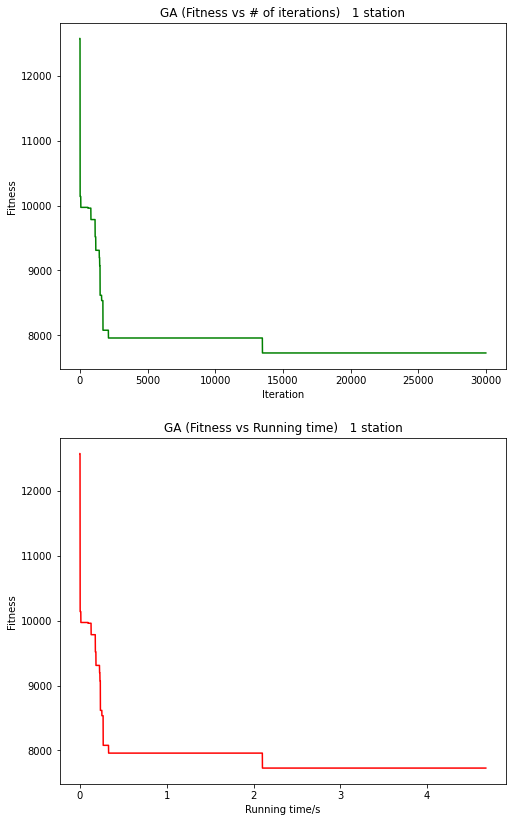

In [14]:
fig, ax = plt.subplots(2, figsize = (8,numberOfStops-2))
ax[0].plot(best_outputs, 'green')
ax[0].set_xlabel("Iteration", fontsize = 10)
ax[0].set_ylabel("Fitness", fontsize = 10)
ax[0].set_title("GA (Fitness vs # of iterations)   1 station", fontsize = 12)

ax[1].plot(running_time, best_outputs, 'red')
ax[1].set_xlabel("Running time/s", fontsize = 10)
ax[1].set_ylabel("Fitness", fontsize = 10)
ax[1].set_title("GA (Fitness vs Running time)   1 station", fontsize = 12)
plt.show()

In [15]:
#Visualization

optimalRoute = new_population[best_index, :]
optimalRoute = optimalRoute[0][0]
currentRoute = G[POIS[optimalRoute[0]]][POIS[optimalRoute[1]]]['route']['coords']
for i in range(1,len(optimalRoute)-1):
    currentRoute += G[POIS[optimalRoute[i]-1]][POIS[optimalRoute[i+1]-1]]['route']['coords']
drawRouteOrder(route = currentRoute, POIS = list(G.nodes), order= list(new_population[best_index][0]))